In [7]:
import json
import os
import pandas as pd
import isodate
import requests
import numpy as np
import cv2
from collections import Counter
from sklearn.cluster import KMeans
import time
from tqdm import tqdm
import random

In [242]:
merge_df=pd.read_csv("final_video_datas.csv", encoding="utf-8-sig")

In [244]:
merge_df.info()
merge_df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7308 entries, 0 to 7307
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title_x             7308 non-null   object 
 1   video_id            7308 non-null   object 
 2   published_date      7308 non-null   object 
 3   thumbnail_url       7308 non-null   object 
 4   view_count          7308 non-null   float64
 5   like_count          7175 non-null   float64
 6   comment_count       7121 non-null   float64
 7   duration            7308 non-null   float64
 8   channel_id          7308 non-null   object 
 9   subscriber_count    7308 non-null   float64
 10  brightness          7308 non-null   float64
 11  contrast            7308 non-null   float64
 12  dominant_colors     7308 non-null   object 
 13  thumbnail_size      7308 non-null   object 
 14  object_labels       7308 non-null   object 
 15  text_positions      7308 non-null   object 
 16  person

,title_x,video_id,published_date,thumbnail_url,view_count,like_count,comment_count,duration,channel_id,subscriber_count,...,word_count,emoji_count,has_emoji,special_char_count,is_clickbait,has_question_mark,has_exclamation,top_noun_1,top_noun_2,top_noun_3
count,7308,7308,7308,7308,7.308000e+03,7175.000000,7121.000000,7308.000000,7308,7.308000e+03,...,7308.000000,7308.000000,7308.000000,7308.000000,7308.000000,7308,7308,7283,7128,6846
unique,7289,7308,1073,7308,NaN,NaN,NaN,NaN,2453,NaN,...,NaN,NaN,NaN,NaN,NaN,2,2,2789,3106,3158
top,[12뉴스] 오늘의 주요뉴스 / SBS,t-zwVkTOZA8,2025-03-28,https://i.ytimg.com/vi/t-zwVkTOZA8/maxresdefau...,NaN,NaN,NaN,NaN,"(' YTN', '@ytnnews24')",NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,테슬라,버라이어티,하바나
freq,11,1,221,1,NaN,NaN,NaN,NaN,201,NaN,...,NaN,NaN,NaN,NaN,NaN,5861,5578,284,101,67
mean,NaN,NaN,NaN,NaN,6.481823e+05,9409.151916,782.451341,925.517378,NaN,1.517002e+06,...,19.960865,0.351259,0.197729,4.297072,0.057745,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,1.460531e+06,29279.895063,3528.673610,709.398507,NaN,3.908397e+06,...,9.051113,0.860403,0.398314,3.278131,0.233276,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,4.320000e+02,0.000000,0.000000,60.000000,NaN,5.280000e+02,...,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,3.151825e+04,466.500000,62.000000,355.750000,NaN,1.190000e+05,...,14.000000,0.000000,0.000000,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,1.465250e+05,2099.000000,205.000000,780.000000,NaN,4.610000e+05,...,19.000000,0.000000,0.000000,4.000000,0.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,6.055885e+05,7457.500000,664.000000,1301.000000,NaN,1.880000e+06,...,25.000000,0.000000,0.000000,6.000000,0.000000,NaN,NaN,NaN,NaN,NaN


In [19]:
cat_cols = ['has_emoji', 'is_clickbait', 'has_question_mark', 'has_exclamation']
for col in cat_cols:
    print(merge_df[col].value_counts())

0    5863
1    1445
Name: has_emoji, dtype: int64
0    6886
1     422
Name: is_clickbait, dtype: int64
False    5861
True     1447
Name: has_question_mark, dtype: int64
False    5578
True     1730
Name: has_exclamation, dtype: int64


In [246]:
def fill_by_group_median(df, group_col, target_col):
    return df[target_col].fillna(
        df.groupby(group_col)[target_col].transform('median')
    )

# 1. 결측 여부 피처
merge_df['like_missing'] = merge_df['like_count'].isnull().astype(int)
merge_df['comment_missing'] = merge_df['comment_count'].isnull().astype(int)

# 2. 구독자수 구간화 → subscriber_group 컬럼 생성
merge_df['subscriber_group'] = pd.qcut(
    merge_df['subscriber_count'], 
    q=5,
    labels=False,
    duplicates='drop'
)

# 3. subscriber_group 기준으로 중앙값 채우기
merge_df['like_count'] = fill_by_group_median(merge_df, 'subscriber_group', 'like_count')
merge_df['comment_count'] = fill_by_group_median(merge_df, 'subscriber_group', 'comment_count')

In [248]:
merge_df['published_date'] = pd.to_datetime(merge_df['published_date'])
merge_df['pub_year'] = merge_df['published_date'].dt.year
merge_df['pub_month'] = merge_df['published_date'].dt.month
merge_df['pub_weekday'] = merge_df['published_date'].dt.weekday

In [71]:
# 트리기반모델 쓰는 경우 생략 가능
# from sklearn.preprocessing import MinMaxScaler
# # 정규화
# scaler = MinMaxScaler()
# scaled_cols = ['like_count', 'comment_count', 'subscriber_count', 'duration', 'brightness', 'contrast']
# merge_df[scaled_cols] = scaler.fit_transform(merge_df[scaled_cols])

### 주요단어 벡터화

#### TF-IDF

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

# 1. 주요 명사 결합
merge_df['nouns_combined'] = merge_df[['top_noun_1', 'top_noun_2', 'top_noun_3']].fillna('').apply(
    lambda row: ' '.join([str(noun).strip() for noun in row if str(noun).strip() != '']), axis=1
)

# 2. TF-IDF 벡터화
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(merge_df['nouns_combined'])

# 3. 전체 단어별 평균 TF-IDF를 계산해 상위 n개 선택
tfidf_means = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
top_n = 30
top_n_indices = np.argsort(tfidf_means)[::-1][:top_n]
top_n_features = [tfidf.get_feature_names_out()[i] for i in top_n_indices]

# 4. 상위 단어만 선택한 DataFrame 만들기
top_n_matrix = tfidf_matrix[:, top_n_indices]
top_n_df = pd.DataFrame(top_n_matrix.toarray(), columns=[f"tfidf_{word}" for word in top_n_features])

# 5. 병합
merge_df = pd.concat([merge_df.reset_index(drop=True), top_n_df.reset_index(drop=True)], axis=1)

'tfidf_테슬라', 'tfidf_뉴스', 'tfidf_전기차', 'tfidf_닌텐도',
       'tfidf_아이폰', 'tfidf_스위치', 'tfidf_게임', 'tfidf_경제', 'tfidf_한국',
       'tfidf_인공', 'tfidf_여행', 'tfidf_버라이어티', 'tfidf_미국', 'tfidf_호텔',
       'tfidf_일상', 'tfidf_먹방', 'tfidf_운동', 'tfidf_중국', 'tfidf_지능', 'tfidf_갱생',
       'tfidf_하바나', 'tfidf_메이크업', 'tfidf_트럼프', 'tfidf_머스크', 'tfidf_지금',
       'tfidf_이유', 'tfidf_토크쇼', 'tfidf_일본', 'tfidf_사람', 'tfidf_패션'

#### 차원 축소

In [81]:
from sklearn.decomposition import TruncatedSVD

# 기존 TF-IDF 전체 벡터 그대로 사용
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(merge_df['nouns_combined'])

# SVD로 차원 축소
svd = TruncatedSVD(n_components=20, random_state=42)
svd_matrix = svd.fit_transform(tfidf_matrix)

# SVD 결과를 DataFrame으로 변환
svd_df = pd.DataFrame(svd_matrix, columns=[f"tfidf_svd_{i+1}" for i in range(svd_matrix.shape[1])])

# 병합
merge_df = pd.concat([merge_df.reset_index(drop=True), svd_df.reset_index(drop=True)], axis=1)

 'tfidf_svd_1', 'tfidf_svd_2', 'tfidf_svd_3', 'tfidf_svd_4',
       'tfidf_svd_5', 'tfidf_svd_6', 'tfidf_svd_7', 'tfidf_svd_8',
       'tfidf_svd_9', 'tfidf_svd_10', 'tfidf_svd_11', 'tfidf_svd_12',
       'tfidf_svd_13', 'tfidf_svd_14', 'tfidf_svd_15', 'tfidf_svd_16',
       'tfidf_svd_17', 'tfidf_svd_18', 'tfidf_svd_19', 'tfidf_svd_20'

## 객체 & 텍스트 전처리

In [250]:
import ast
# 문자열을 실제 리스트로 변환 (object_labels 칼럼에만 적용)
merge_df['object_labels'] = merge_df['object_labels'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
merge_df['dominant_colors'] = merge_df['dominant_colors'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

def safe_literal_eval(val):
    if isinstance(val, str):
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            return []
    return val if isinstance(val, list) else []

# 적용
merge_df['person_positions'] = merge_df['person_positions'].apply(safe_literal_eval)
merge_df['text_positions'] = merge_df['text_positions'].apply(safe_literal_eval)

In [45]:
color_li=[]
for i in merge_df['dominant_colors']:
    for j in i:
        color_li.append(j[0])

set(color_li)

{'aliceblue',
 'antiquewhite',
 'aquamarine',
 'azure',
 'beige',
 'bisque',
 'black',
 'blanchedalmond',
 'blue',
 'blueviolet',
 'brown',
 'burlywood',
 'cadetblue',
 'chartreuse',
 'chocolate',
 'coral',
 'cornflowerblue',
 'cornsilk',
 'crimson',
 'cyan',
 'darkblue',
 'darkcyan',
 'darkgoldenrod',
 'darkgray',
 'darkgreen',
 'darkgrey',
 'darkkhaki',
 'darkmagenta',
 'darkolivegreen',
 'darkorange',
 'darkorchid',
 'darkred',
 'darksalmon',
 'darkseagreen',
 'darkslateblue',
 'darkslategrey',
 'darkturquoise',
 'darkviolet',
 'deeppink',
 'deepskyblue',
 'dimgrey',
 'dodgerblue',
 'firebrick',
 'floralwhite',
 'forestgreen',
 'gainsboro',
 'ghostwhite',
 'gold',
 'goldenrod',
 'green',
 'greenyellow',
 'grey',
 'honeydew',
 'hotpink',
 'indianred',
 'indigo',
 'ivory',
 'khaki',
 'lavender',
 'lavenderblush',
 'lawngreen',
 'lemonchiffon',
 'lightblue',
 'lightcoral',
 'lightcyan',
 'lightgoldenrodyellow',
 'lightgray',
 'lightgreen',
 'lightgrey',
 'lightpink',
 'lightsalmon',
 '

In [252]:
from collections import Counter, defaultdict
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import numpy as np
import ast

def preprocess_for_model(df, top_tfidf_n=50):
    df = df.copy()

    color_groups = {
        'red': {'red', 'crimson', 'firebrick', 'darkred', 'salmon', 'indianred', 'tomato', 'orangered'},
        'blue': {'blue', 'navy', 'dodgerblue', 'deepskyblue', 'royalblue', 'skyblue', 'slateblue', 'mediumblue'},
        'green': {'green', 'lime', 'forestgreen', 'seagreen', 'springgreen', 'mediumseagreen', 'darkgreen', 'lawngreen'},
        'yellow': {'yellow', 'gold', 'khaki', 'lemonchiffon', 'lightyellow', 'palegoldenrod'},
        'purple': {'purple', 'magenta', 'violet', 'orchid', 'mediumorchid', 'mediumpurple', 'darkviolet'},
        'brown': {'brown', 'sienna', 'chocolate', 'peru', 'saddlebrown', 'tan', 'burlywood'},
        'grey': {'grey', 'gray', 'lightgrey', 'darkgrey', 'dimgrey', 'slategrey', 'gainsboro'},
        'white': {'white', 'snow', 'ivory', 'ghostwhite', 'whitesmoke', 'floralwhite', 'seashell'},
        'pink': {'pink', 'lightpink', 'hotpink', 'lavenderblush'},
        'other': set()
    }

    def map_color_to_group(color):
        for group, colors in color_groups.items():
            if color.lower() in colors:
                return group
        return 'other'

    for col in color_groups.keys():
        df[f'color_{col}'] = 0.0

    def count_color_groups(color_list):
        counter = defaultdict(float)
        for color, prob in color_list:
            group = map_color_to_group(color)
            counter[group] += prob
        return counter

    for idx, row in df.iterrows():
        if isinstance(row['dominant_colors'], list):
            counter = count_color_groups(row['dominant_colors'])
            for group in counter:
                df.at[idx, f'color_{group}'] = counter[group]

    df['person_count'] = df['object_labels'].apply(lambda x: x.count('person') if isinstance(x, list) else 0)

    all_objects = []
    for x in df['object_labels']:
        if isinstance(x, list):
            all_objects.extend([obj for obj in x if obj != 'person'])

    top_objects = [obj for obj, _ in Counter(all_objects).most_common(10)]

    for obj in top_objects:
        df[f'obj_{obj}'] = df['object_labels'].apply(lambda x: int(obj in x) if isinstance(x, list) else 0)

    df['has_text'] = df['text_positions'].apply(lambda x: int(x != ['텍스트 없음']))
    df['has_person_pos'] = df['person_positions'].apply(lambda x: int(x != ['사람 없음']))

    # tfidf = TfidfVectorizer(max_features=top_tfidf_n)
    # tfidf_matrix = tfidf.fit_transform(df['title_x'].fillna(''))
    # tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'tfidf_{w}' for w in tfidf.get_feature_names_out()])
    # df = pd.concat([df.reset_index(drop=True), tfidf_df], axis=1)

    return df

In [254]:
model_df = preprocess_for_model(merge_df)

In [255]:
# 사람 위치
model_df['person_left'] = model_df['person_positions'].apply(lambda x: sum('left' in p for p in x))
model_df['person_middle'] = model_df['person_positions'].apply(lambda x: sum('middle' in p for p in x))
model_df['person_right'] = model_df['person_positions'].apply(lambda x: sum('right' in p for p in x))
model_df['person_small'] = model_df['person_positions'].apply(lambda x: sum('s' in p for p in x))
model_df['person_medium'] = model_df['person_positions'].apply(lambda x: sum('m' in p for p in x))
model_df['person_large'] = model_df['person_positions'].apply(lambda x: sum('l' in p for p in x))

# 텍스트 위치
model_df['text_left'] = model_df['text_positions'].apply(lambda x: sum('left' in p for p in x))
model_df['text_middle'] = model_df['text_positions'].apply(lambda x: sum('middle' in p for p in x))
model_df['text_right'] = model_df['text_positions'].apply(lambda x: sum('right' in p for p in x))
model_df['text_small'] = model_df['text_positions'].apply(lambda x: sum('s' in p for p in x))
model_df['text_medium'] = model_df['text_positions'].apply(lambda x: sum('m' in p for p in x))
model_df['text_large'] = model_df['text_positions'].apply(lambda x: sum('l' in p for p in x))

In [296]:
model_columns=['view_count', 'duration',
       'subscriber_count', 'brightness', 'contrast', 'title_length', 'word_count', 'emoji_count', 'has_emoji',
       'special_char_count', 'is_clickbait', 'has_question_mark',
       'has_exclamation', 'pub_year', 'pub_month', 'pub_weekday',
       'color_red', 'color_blue', 'color_green', 'color_yellow',
       'color_purple', 'color_brown', 'color_grey', 'color_white',
       'color_pink', 'color_other', 
        'person_count',
        'obj_bowl', 'obj_없음', 'obj_car', 'obj_tie', 'obj_chair', 'obj_cake', 'obj_cup',
       'obj_cell phone', 'obj_bottle', 'obj_teddy bear', 
        'has_text', 'has_person_pos', 'person_left', 'person_middle', 'person_right',
       'person_small', 'person_medium', 'person_large', 'text_left',
       'text_middle', 'text_right', 'text_small', 'text_medium', 'text_large']

model_df=model_df[model_columns]

In [298]:
model_df.to_csv('model_datas_2.csv', index=False, encoding="utf-8-sig",)

In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

sns.set(style="whitegrid")

# 데이터 로딩
df = pd.read_csv("model_datas_2.csv")
df["log_view_count"] = np.log1p(df["view_count"])  # log(1 + x)

# Feature/Target 분리
X = df.drop(columns=["view_count","log_view_count"])
y = df["log_view_count"]

# 로그 변환
y_log = np.log1p(y)

# 학습 데이터 분할
X_train, X_val, y_train_log, y_val_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train_log)
    y_pred_log = model.predict(X_val)
    y_pred = np.expm1(y_pred_log)  # 로그 복원
    y_true = np.expm1(y_val_log)

    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)

    results[name] = {"model": model, "rmse": rmse, "r2": r2}

    print(f"{name} RMSE: {rmse:,.2f}")
    print(f"{name} R²: {r2:.4f}")
    print("-" * 40)

Training RandomForest...
RandomForest RMSE: 1.57
RandomForest R²: 0.4116
----------------------------------------
Training XGBoost...
XGBoost RMSE: 1.59
XGBoost R²: 0.3931
----------------------------------------
Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3250
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 50
[LightGBM] [Info] Start training from score 2.530459
LightGBM RMSE: 1.56
LightGBM R²: 0.4167
----------------------------------------


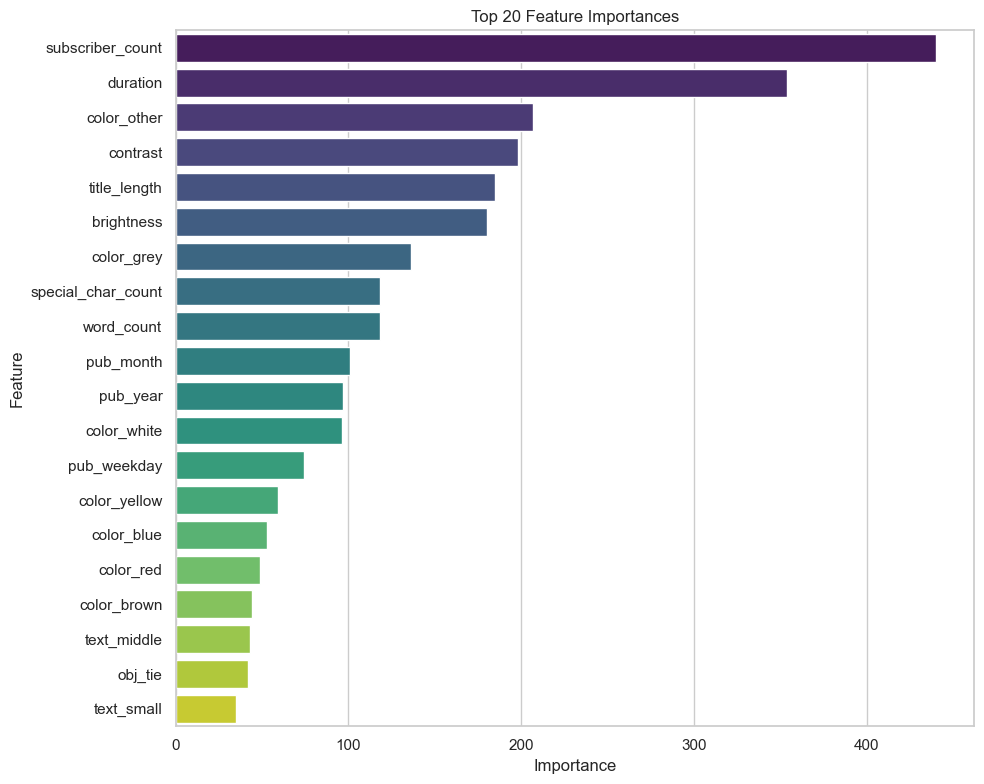

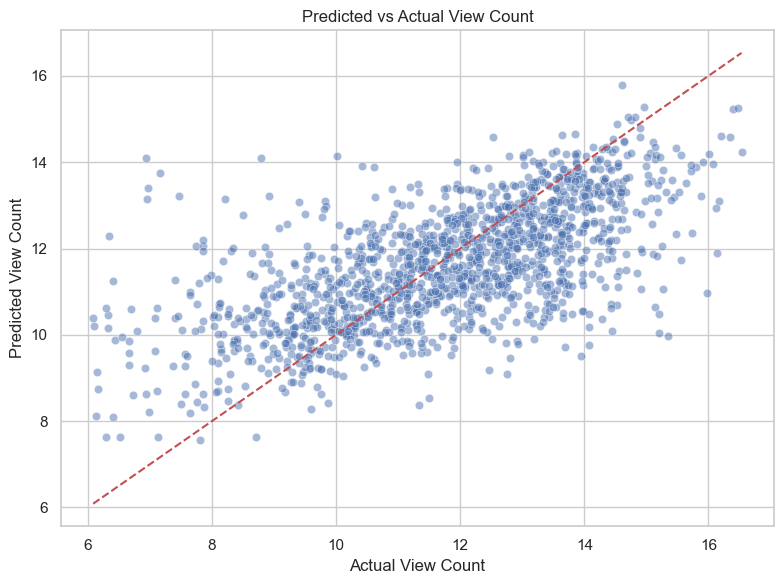

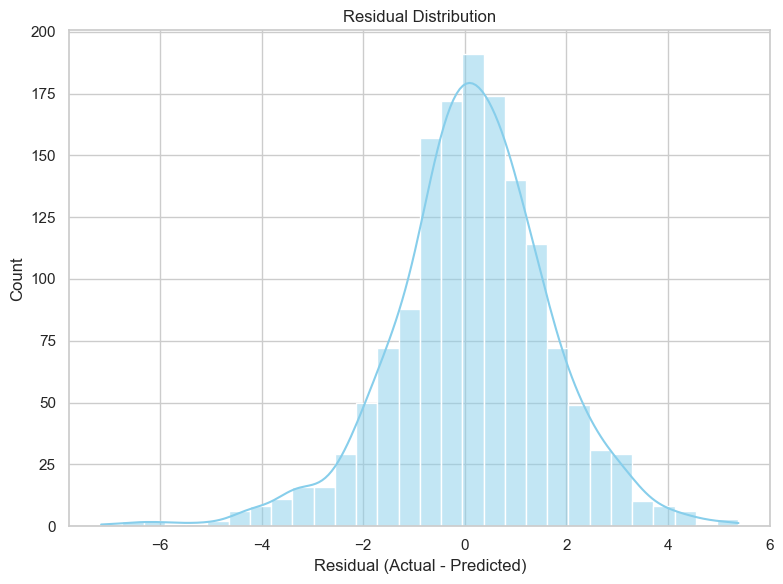

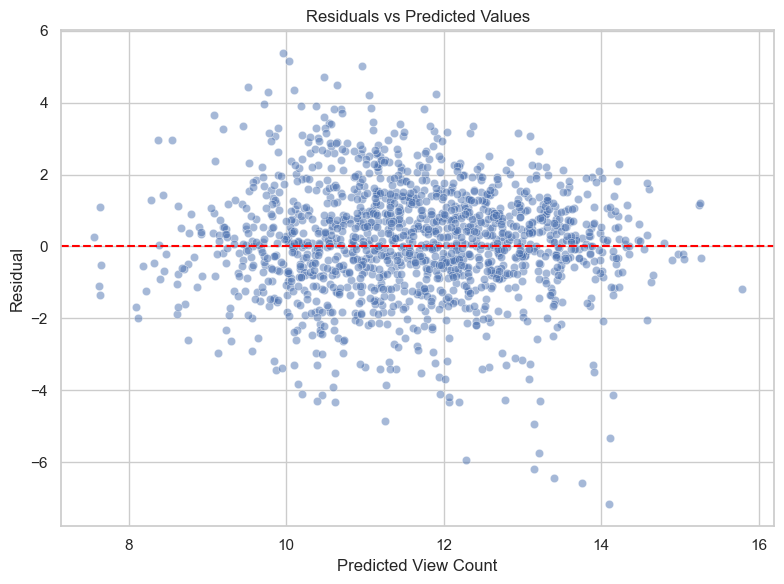

In [302]:
# ─────────────────────────────
# 1. Feature Importance 시각화
# ─────────────────────────────
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=feat_imp[:20], y=feat_imp.index[:20], palette="viridis")
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ─────────────────────────────
# 2. 예측 vs 실제 시각화
# ─────────────────────────────
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual View Count")
plt.ylabel("Predicted View Count")
plt.title("Predicted vs Actual View Count")
plt.tight_layout()
plt.show()

# ─────────────────────────────
# 3. Residuals (잔차 분석)
# ─────────────────────────────
residuals = y_val - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color="skyblue")
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted View Count")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted Values")
plt.tight_layout()
plt.show()

In [328]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

df = pd.read_csv("model_datas_2.csv")
df["log_view_count"] = np.log1p(df["view_count"])  # log(1 + x)

# Feature/Target 분리
X = df.drop(columns=["view_count","log_view_count"])
y = df["log_view_count"]

X_train, X_val, y_train, y_val = train_test_split(X, y_log, test_size=0.2, random_state=42)

# 목적 함수
def objective(trial):
    params = {
        'objective': 'regression',
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'random_state': 42
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
    )

    preds = model.predict(X_val)
    rmse = mean_squared_error(y_val, preds, squared=False)
    return rmse

# Optuna 수행
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# 결과 출력
print("✅ Best RMSE:", study.best_value)
print("📌 Best Params:", study.best_params)

# 최적 파라미터로 모델 재학습
best_params = study.best_params
best_params.update({
    'objective': 'regression',
    'n_estimators': 1000,
    'random_state': 42
})

final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
)

# 평가
y_pred_log = final_model.predict(X_val)
rmse = mean_squared_error(y_val, y_pred_log, squared=False)
r2 = r2_score(y_val, y_pred_log)

print(f"\n📊 Final Model Performance")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


[I 2025-04-07 21:34:53,239] A new study created in memory with name: no-name-92655bb5-341a-4df0-9b97-6c491a7609a2


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3197
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 48
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-04-07 21:34:54,061] Trial 0 finished with value: 0.13331920835038072 and parameters: {'learning_rate': 0.09213544869580124, 'num_leaves': 267, 'max_depth': 8, 'min_child_samples': 98, 'subsample': 0.7286265550847477, 'colsample_bytree': 0.8051779320173102, 'reg_alpha': 2.9208643221509654, 'reg_lambda': 0.9346268751338155}. Best is trial 0 with value: 0.13331920835038072.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-07 21:34:56,376] Trial 1 finished with value: 0.13194005159439645 and parameters: {'learning_rate': 0.02408163378595489, 'num_leaves': 24, 'max_depth': 14, 'min_child_samples': 62, 'subsample': 0.8229510356255708, 'colsample_bytree': 0.692346588173142, 'reg_alpha': 0.5161048476757135, 'reg_lambda': 2.408881356988333}. Best is trial 1 with value: 0.13194005159439645.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3250
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-04-07 21:34:56,897] Trial 2 finished with value: 0.13262870771122715 and parameters: {'learning_rate': 0.187835208889147, 'num_leaves': 55, 'max_depth': 9, 'min_child_samples': 53, 'subsample': 0.8573711278409415, 'colsample_bytree': 0.6529548045881204, 'reg_alpha': 2.3531949988704004, 'reg_lambda': 2.9278877532285668}. Best is trial 1 with value: 0.13194005159439645.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2025-04-07 21:34:59,155] Trial 3 finished with value: 0.13332127539204283 and parameters: {'learning_rate': 0.03175099790030727, 'num_leaves': 73, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.6387655178694285, 'colsample_bytree': 0.5758734076615557, 'reg_alpha': 3.0391056679024366, 'reg_lambda': 4.887398063946695}. Best is trial 1 with value: 0.13194005159439645.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3250
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-07 21:35:02,661] Trial 4 finished with value: 0.13506874522184073 and parameters: {'learning_rate': 0.017986959532009017, 'num_leaves': 56, 'max_depth': 9, 'min_child_samples': 36, 'subsample': 0.6372358883620924, 'colsample_bytree': 0.5637167987301621, 'reg_alpha': 4.514874411697284, 'reg_lambda': 0.4214849530711917}. Best is trial 1 with value: 0.13194005159439645.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3250
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-04-07 21:35:03,125] Trial 5 finished with value: 0.13534606235776717 and parameters: {'learning_rate': 0.1028036671881303, 'num_leaves': 23, 'max_depth': 9, 'min_child_samples': 34, 'subsample': 0.722260748731218, 'colsample_bytree': 0.7671415128461571, 'reg_alpha': 4.804835941457251, 'reg_lambda': 0.9506854737532083}. Best is trial 1 with value: 0.13194005159439645.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-07 21:35:04,220] Trial 6 finished with value: 0.13402613868671967 and parameters: {'learning_rate': 0.10161736313106723, 'num_leaves': 41, 'max_depth': 4, 'min_child_samples': 96, 'subsample': 0.5246712656607226, 'colsample_bytree': 0.5075484440724736, 'reg_alpha': 1.8390234946939588, 'reg_lambda': 0.6636644780714429}. Best is trial 1 with value: 0.13194005159439645.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-07 21:35:04,795] Trial 7 finished with value: 0.13518072836110137 and parameters: {'learning_rate': 0.10576679050914915, 'num_leaves': 178, 'max_depth': 12, 'min_child_samples': 62, 'subsample': 0.9424216723776762, 'colsample_bytree': 0.8268148105171865, 'reg_alpha': 4.334494172013333, 'reg_lambda': 0.8909012781899539}. Best is trial 1 with value: 0.13194005159439645.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-04-07 21:35:05,278] Trial 8 finished with value: 0.13483231830597772 and parameters: {'learning_rate': 0.1734363352863629, 'num_leaves': 243, 'max_depth': 4, 'min_child_samples': 88, 'subsample': 0.7245652859413727, 'colsample_bytree': 0.8391004115437568, 'reg_alpha': 1.1700456368616463, 'reg_lambda': 2.4131630335817187}. Best is trial 1 with value: 0.13194005159439645.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-07 21:35:05,746] Trial 9 finished with value: 0.13507112697500903 and parameters: {'learning_rate': 0.0854993111363758, 'num_leaves': 199, 'max_depth': 4, 'min_child_samples': 43, 'subsample': 0.5408908673883928, 'colsample_bytree': 0.8330085159004299, 'reg_alpha': 3.7479498980828794, 'reg_lambda': 4.153815529654465}. Best is trial 1 with value: 0.13194005159439645.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-07 21:35:07,623] Trial 10 finished with value: 0.13171197444864363 and parameters: {'learning_rate': 0.046932606959649736, 'num_leaves': 120, 'max_depth': 15, 'min_child_samples': 74, 'subsample': 0.8668158450150304, 'colsample_bytree': 0.9761782387580547, 'reg_alpha': 0.06802434341299207, 'reg_lambda': 2.2469311093726567}. Best is trial 10 with value: 0.13171197444864363.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 49
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-07 21:35:09,785] Trial 11 finished with value: 0.13095881355797445 and parameters: {'learning_rate': 0.04870540585123574, 'num_leaves': 118, 'max_depth': 15, 'min_child_samples': 72, 'subsample': 0.8685076947806689, 'colsample_bytree': 0.9929391496751945, 'reg_alpha': 0.0033427033713607224, 'reg_lambda': 2.0993604877610235}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 49
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-07 21:35:11,546] Trial 12 finished with value: 0.1318742894762092 and parameters: {'learning_rate': 0.062056827472366335, 'num_leaves': 118, 'max_depth': 15, 'min_child_samples': 78, 'subsample': 0.9740907915828347, 'colsample_bytree': 0.9822243543812381, 'reg_alpha': 0.11929171053843038, 'reg_lambda': 1.8489078403399604}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 49
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-07 21:35:13,603] Trial 13 finished with value: 0.13193434717496416 and parameters: {'learning_rate': 0.05300873192350529, 'num_leaves': 130, 'max_depth': 12, 'min_child_samples': 76, 'subsample': 0.8836240093892694, 'colsample_bytree': 0.9989636555660566, 'reg_alpha': 0.8701797410596963, 'reg_lambda': 3.309396606524687}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 49
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-07 21:35:14,616] Trial 14 finished with value: 0.13319594711785826 and parameters: {'learning_rate': 0.14624345548131223, 'num_leaves': 117, 'max_depth': 13, 'min_child_samples': 76, 'subsample': 0.8158658936914251, 'colsample_bytree': 0.9280899990232618, 'reg_alpha': 0.023522390288772732, 'reg_lambda': 1.727901831578988}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 49
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-07 21:35:16,407] Trial 15 finished with value: 0.13218354117036635 and parameters: {'learning_rate': 0.05141931382698688, 'num_leaves': 147, 'max_depth': 15, 'min_child_samples': 65, 'subsample': 0.9175223788041224, 'colsample_bytree': 0.9160724359712169, 'reg_alpha': 1.474641392877788, 'reg_lambda': 1.7759974780452707}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3250
[LightGBM] [Info] Number of data points in the train set: 58

[I 2025-04-07 21:35:18,011] Trial 16 finished with value: 0.13217238692535493 and parameters: {'learning_rate': 0.07147735846939246, 'num_leaves': 214, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.9905897375004121, 'colsample_bytree': 0.9172028947446487, 'reg_alpha': 0.6489090774416726, 'reg_lambda': 3.4765320078315245}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 49
[LightGBM] [Warning] Found whitespace in fe

[I 2025-04-07 21:35:20,593] Trial 17 finished with value: 0.13247279900943157 and parameters: {'learning_rate': 0.03856135192480592, 'num_leaves': 91, 'max_depth': 6, 'min_child_samples': 86, 'subsample': 0.7979256976201948, 'colsample_bytree': 0.8888018624149606, 'reg_alpha': 1.811172159278181, 'reg_lambda': 0.048275327382528044}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3250
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-07 21:35:21,707] Trial 18 finished with value: 0.1333520825761017 and parameters: {'learning_rate': 0.13452030988263156, 'num_leaves': 96, 'max_depth': 11, 'min_child_samples': 53, 'subsample': 0.873366572197151, 'colsample_bytree': 0.9636155208361372, 'reg_alpha': 0.4040002372163645, 'reg_lambda': 1.466251883022184}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Foun

[I 2025-04-07 21:35:26,197] Trial 19 finished with value: 0.1325051684274761 and parameters: {'learning_rate': 0.012707975491260903, 'num_leaves': 167, 'max_depth': 14, 'min_child_samples': 70, 'subsample': 0.9214854079133628, 'colsample_bytree': 0.8804425951111784, 'reg_alpha': 1.1376101944755457, 'reg_lambda': 2.920213243467065}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 49
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-04-07 21:35:26,928] Trial 20 finished with value: 0.1337320069460929 and parameters: {'learning_rate': 0.12561892286676762, 'num_leaves': 293, 'max_depth': 13, 'min_child_samples': 82, 'subsample': 0.7930917310369867, 'colsample_bytree': 0.7148503161251732, 'reg_alpha': 2.340178027129386, 'reg_lambda': 3.8986154819406775}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-07 21:35:28,768] Trial 21 finished with value: 0.13228249325530803 and parameters: {'learning_rate': 0.06559957857597387, 'num_leaves': 118, 'max_depth': 15, 'min_child_samples': 74, 'subsample': 0.9965801521151473, 'colsample_bytree': 0.9906596505182395, 'reg_alpha': 0.05903078160111566, 'reg_lambda': 2.0400110070747894}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 49
[LightGBM] [Warning] Found whitespace in fe

[I 2025-04-07 21:35:30,183] Trial 22 finished with value: 0.1322388142341626 and parameters: {'learning_rate': 0.047132633658962114, 'num_leaves': 149, 'max_depth': 15, 'min_child_samples': 90, 'subsample': 0.9525026260507465, 'colsample_bytree': 0.9585902701160611, 'reg_alpha': 0.03209014765476503, 'reg_lambda': 2.3325789851515237}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-07 21:35:31,794] Trial 23 finished with value: 0.13254384125118016 and parameters: {'learning_rate': 0.06861782095501792, 'num_leaves': 90, 'max_depth': 14, 'min_child_samples': 81, 'subsample': 0.8913114583494617, 'colsample_bytree': 0.9570380909984332, 'reg_alpha': 0.49872646796816106, 'reg_lambda': 1.252479061709967}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Foun

[I 2025-04-07 21:35:33,434] Trial 24 finished with value: 0.13225118933486243 and parameters: {'learning_rate': 0.07913349033813541, 'num_leaves': 131, 'max_depth': 13, 'min_child_samples': 69, 'subsample': 0.9640584654011832, 'colsample_bytree': 0.8770337496674547, 'reg_alpha': 0.9190134486936944, 'reg_lambda': 2.8403015525314266}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3250
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-07 21:35:36,026] Trial 25 finished with value: 0.13224693942176355 and parameters: {'learning_rate': 0.038518822184874166, 'num_leaves': 187, 'max_depth': 15, 'min_child_samples': 59, 'subsample': 0.8417742466058343, 'colsample_bytree': 0.9939277124665613, 'reg_alpha': 0.3737181141613835, 'reg_lambda': 2.0589295924196147}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3250
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-07 21:35:38,076] Trial 26 finished with value: 0.13323462344580186 and parameters: {'learning_rate': 0.0594923275546424, 'num_leaves': 104, 'max_depth': 11, 'min_child_samples': 49, 'subsample': 0.77656934305818, 'colsample_bytree': 0.9473895404526456, 'reg_alpha': 1.4922123779160734, 'reg_lambda': 1.4298117379459112}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 49
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-07 21:35:40,238] Trial 27 finished with value: 0.13314299980039104 and parameters: {'learning_rate': 0.0341548988341479, 'num_leaves': 150, 'max_depth': 14, 'min_child_samples': 79, 'subsample': 0.8875231170252824, 'colsample_bytree': 0.8938312325181815, 'reg_alpha': 0.8106592006312829, 'reg_lambda': 1.8326252201190742}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 49
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-07 21:35:41,348] Trial 28 finished with value: 0.1327588421375806 and parameters: {'learning_rate': 0.11884777327766684, 'num_leaves': 75, 'max_depth': 12, 'min_child_samples': 69, 'subsample': 0.9193948289731849, 'colsample_bytree': 0.7711610876990742, 'reg_alpha': 0.25692645846636064, 'reg_lambda': 2.12994161081374}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-07 21:35:42,621] Trial 29 finished with value: 0.1349471876715219 and parameters: {'learning_rate': 0.09010337780140018, 'num_leaves': 222, 'max_depth': 6, 'min_child_samples': 93, 'subsample': 0.7671395134019946, 'colsample_bytree': 0.8491185675491869, 'reg_alpha': 3.5437471250141366, 'reg_lambda': 2.722775051307857}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2025-04-07 21:35:43,753] Trial 30 finished with value: 0.13363830482925884 and parameters: {'learning_rate': 0.0735324506318275, 'num_leaves': 131, 'max_depth': 13, 'min_child_samples': 100, 'subsample': 0.6768343716639573, 'colsample_bytree': 0.8019784756048529, 'reg_alpha': 2.7874037259768394, 'reg_lambda': 1.4576968532784502}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-07 21:35:46,217] Trial 31 finished with value: 0.13182512361346513 and parameters: {'learning_rate': 0.05156929882683696, 'num_leaves': 130, 'max_depth': 12, 'min_child_samples': 73, 'subsample': 0.8585203469720866, 'colsample_bytree': 0.9993728673345221, 'reg_alpha': 0.9711109225033046, 'reg_lambda': 3.2039515715816584}. Best is trial 11 with value: 0.13095881355797445.
Exception ignored on calling ctypes callback function: <function _log_callback at 0x0000019C1C392340>
Traceback (most recent call last):
  File "C:\Users\duwjd\anaconda3\Lib\site-packages\lightgbm\basic.py", line 257, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 49
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-07 21:35:48,585] Trial 32 finished with value: 0.13251420566332925 and parameters: {'learning_rate': 0.02547394368527314, 'num_leaves': 113, 'max_depth': 15, 'min_child_samples': 85, 'subsample': 0.8348131845392553, 'colsample_bytree': 0.9733607079928196, 'reg_alpha': 0.36911270198471013, 'reg_lambda': 3.3405752607815273}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 49
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-07 21:35:51,321] Trial 33 finished with value: 0.13212848777761824 and parameters: {'learning_rate': 0.04938283870135838, 'num_leaves': 163, 'max_depth': 14, 'min_child_samples': 72, 'subsample': 0.856649480824066, 'colsample_bytree': 0.9285529271320312, 'reg_alpha': 0.6809292290968321, 'reg_lambda': 2.602358180115245}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 49
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-07 21:35:52,653] Trial 34 finished with value: 0.13228346733035698 and parameters: {'learning_rate': 0.06021837016946257, 'num_leaves': 75, 'max_depth': 10, 'min_child_samples': 65, 'subsample': 0.9728285382120132, 'colsample_bytree': 0.9391168886031913, 'reg_alpha': 1.3549897419526489, 'reg_lambda': 3.1215920583132717}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3250
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Exception ignored on calling ctypes callback function: <function _log_callback at 0x0000019C1C392340>
Traceback (most recent call last):
  File "C:\Users\duwjd\anaconda3\Lib\site-packages\lightgbm\basic.py", line 257, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-07 21:35:55,788] Trial 35 finished with value: 0.13256409777358485 and parameters: {'learning_rate': 0.025434124317194124, 'num_leaves': 138, 'max_depth': 14, 'min_child_samples': 58, 'subsample': 0.9157936662773792, 'colsample_bytree': 0.9754974585784121, 'reg_alpha': 0.21011039119623712, 'reg_lambda': 3.963135259361488}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 49
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-07 21:35:58,285] Trial 36 finished with value: 0.13263290776192616 and parameters: {'learning_rate': 0.038331370036009435, 'num_leaves': 50, 'max_depth': 10, 'min_child_samples': 78, 'subsample': 0.743732849426304, 'colsample_bytree': 0.6454969915789136, 'reg_alpha': 1.8174939614204808, 'reg_lambda': 3.6284717053592868}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3250
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-07 21:35:59,687] Trial 37 finished with value: 0.1325407250555945 and parameters: {'learning_rate': 0.0829795066824901, 'num_leaves': 111, 'max_depth': 13, 'min_child_samples': 48, 'subsample': 0.8606505727334262, 'colsample_bytree': 0.9029081358197194, 'reg_alpha': 1.039278255515849, 'reg_lambda': 4.392304512821176}. Best is trial 11 with value: 0.13095881355797445.
Exception ignored on calling ctypes callback function: <function _log_callback at 0x0000019C1C392340>
Traceback (most recent call last):
  File "C:\Users\duwjd\anaconda3\Lib\site-packages\lightgbm\basic.py", line 257, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 49
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-07 21:36:02,748] Trial 38 finished with value: 0.13234144368420162 and parameters: {'learning_rate': 0.02351153256954991, 'num_leaves': 67, 'max_depth': 8, 'min_child_samples': 64, 'subsample': 0.695289576205128, 'colsample_bytree': 0.863026386153183, 'reg_alpha': 0.6299271130340178, 'reg_lambda': 2.1682971707014405}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3250
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-04-07 21:36:04,942] Trial 39 finished with value: 0.13274509255113762 and parameters: {'learning_rate': 0.09702754614454215, 'num_leaves': 172, 'max_depth': 15, 'min_child_samples': 58, 'subsample': 0.8205773989269931, 'colsample_bytree': 0.9970351766664126, 'reg_alpha': 0.19591514079557612, 'reg_lambda': 2.501478694203228}. Best is trial 11 with value: 0.13095881355797445.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 5846, number of used features: 49
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.530459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-07 21:36:10,284] Trial 40 finished with value: 0.13229258234876679 and parameters: {'learning_rate': 0.013385897427858312, 'num_leaves': 85, 'max_depth': 12, 'min_child_samples': 84, 'subsample': 0.5738461397980065, 'colsample_bytree': 0.942603139253607, 'reg_alpha': 0.5698946354187917, 'reg_lambda': 4.986547336261051}. Best is trial 11 with value: 0.13095881355797445.
[W 2025-04-07 21:36:10,427] Trial 41 failed with parameters: {'learning_rate': 0.05299584253110913, 'num_leaves': 128, 'max_depth': 12, 'min_child_samples': 75, 'subsample': 0.8967977245951456, 'colsample_bytree': 0.9996222008506921, 'reg_alpha': 0.8900841521995035, 'reg_lambda': 3.1154248995077554} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\duwjd\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\duwjd\AppData\Local\Temp\ipykernel_13024